In [1]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=d626433468cb7699286e9c05f09226de20bdad09fd9ef2d72e036d3df0334329
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.0 MB/s eta 0:00:00


**Installing dependencies**

In [2]:
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
# import basic plot tools
from qiskit.visualization import circuit_drawer, plot_state_city, plot_state_qsphere, plot_bloch_multivector, plot_state_hinton, plot_state_paulivec
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import plot_histogram


**Hidden Shift Problem**

In [3]:
class hidden_shift:
    def __init__(self, n, s):
        self.n = n
        self.s = s
        self.qc = self.prepare_circuit()
        self.qc1 = self.prepare_circuit1()
        self.simulator = AerSimulator()
        self.result = None

    def prepare_circuit(self):
        qc = QuantumCircuit(self.n,self.n)
        # Apply Hadamard gates to make superposition
        for i in range(self.n):
            qc.h(i)
        qc.barrier()  # barrier is for visual separation

        # Query the oracle g by appending the oracle circuit
        qc.append(self.oracle_g(), range(self.n))
        qc.barrier()

        # Apply Hadamard gates to perform a boolean Fourier transform
        for i in range(self.n):
            qc.h(i)
        qc.barrier()

        # Query the oracle f tilde
        qc.append(self.oracle_f_tilde(), range(self.n))
        qc.barrier()

        # Retrieve s by performing the boolean Fourier transform again
        for i in range(self.n):
            qc.h(i)
        qc.barrier()

        # Measure all qubits
        for i in range(self.n):
            qc.measure(i, i)
        return qc

    def prepare_circuit1(self):
        qc1 = QuantumCircuit(self.n,self.n)
        # Apply Hadamard gates to make superposition
        for i in range(self.n):
            qc1.h(i)
        qc1.barrier()  # barrier is for visual separation

        # Query the oracle g by appending the oracle circuit
        qc1.append(self.oracle_g(), range(self.n))
        qc1.barrier()

        # Apply Hadamard gates to perform a boolean Fourier transform
        for i in range(self.n):
            qc1.h(i)
        qc1.barrier()

        # Query the oracle f tilde
        qc1.append(self.oracle_f_tilde(), range(self.n))
        qc1.barrier()

        # Retrieve s by performing the boolean Fourier transform again
        for i in range(self.n):
            qc1.h(i)
        qc1.barrier()
        return qc1

    def shift_s(self):
        """Shifting operation for the given string s"""
        shift_s = QuantumCircuit(self.n)
        s = self.s[::-1]  # reverse s to fit qiskit's qubit ordering
        for i in range(self.n):
            if s[i] == '0':
                continue
            else:
                shift_s.x(i)  # apply x gates to shift the input
        shift_s.name = 'Shift'
        return shift_s

    def oracle_g(self):
        """Oracle circuit that encodes g = U_g"""
        oracle_g = QuantumCircuit(self.n)

        # Shift the inputs
        oracle_g.append(self.shift_s(), range(self.n))

        # Apply the oracle U_f = (-1)^f(x) = F(x)
        # x·y corresponds to controlled-z gates between first half qubits and second half qubits
        for i in range(int(self.n/2)):
            oracle_g.cz(i, i+int(self.n/2))

        # h(x) = x·e_2 corresponds to the z gate on the second qubit = q1
        oracle_g.z(1)

        # Undo the shift
        oracle_g.append(self.shift_s(), range(self.n))

        oracle_g.name = 'Oracle g'
        return oracle_g

    def oracle_f_tilde(self):
        """Oracle circuit that encodes Fourier transformed f = U_f tilde"""
        oracle_f_tilde = QuantumCircuit(self.n)

        # Apply the oracle U_f tilde
        # x·y corresponds to controlled-z gates between first half qubits and second half qubits
        for i in range(int(self.n/2)):
            oracle_f_tilde.cz(i, i+int(self.n/2))

        # Apply h(y) = y·e_2, which corresponds to the z gate on the second qubit of the second register = q3
        oracle_f_tilde.z(3)

        oracle_f_tilde.name = 'Oracle f tilde'
        return oracle_f_tilde

    def run_simulation(self, shots=1024):
        transpiled_qc = transpile(self.qc, self.simulator)
        job = self.simulator.run(transpiled_qc, shots=shots)
        self.result = job.result()

    def run_simulation1(self, shots=1024):
        transpiled_qc = transpile(self.qc1, self.simulator)
        job = self.simulator.run(transpiled_qc, shots=shots)
        self.result = job.result()

    def get_counts(self):
        if self.result:
            counts = self.result.get_counts(self.qc)
            return counts
        else:
            raise RuntimeError("Simulation has not been run yet.")

    def plot_result(self):
        if self.result:
            counts = self.result.get_counts(self.qc)
            return plot_histogram(counts)
        else:
            raise RuntimeError("Simulation has not been run yet.")

    def psi(self):
        psi = Statevector(self.qc1)  # Ensure correct method for statevector creation
        return psi

    def get_density(self):
        psi = Statevector(self.qc1)
        return DensityMatrix(psi).draw("latex").data

    def get_city(self):
        psi = Statevector(self.qc1)
        return plot_state_city(psi)

    def get_circuit(self):
        return circuit_drawer(self.qc, output='mpl', filename='circuit.png')

    def get_hinton(self):
        psi = Statevector(self.qc1)
        return plot_state_hinton(psi)

    def get_paulivec(self):
        psi = Statevector(self.qc1)
        return plot_state_paulivec(psi)

    def get_qsphere(self):
        psi = Statevector(self.qc1)
        return plot_state_qsphere(psi)

    def get_bloch(self):
        psi = Statevector(self.qc1)
        return plot_bloch_multivector(psi)

**Running simulation with measurement**

In [4]:
simulator = hidden_shift(4, '1100')
simulator.run_simulation()

**Counts**

In [5]:
simulator.get_counts()

{'1100': 1024}

**Running simuation wihout measurements**

In [6]:
simulator.run_simulation1()

**Density matrix**

In [7]:
from IPython.display import display, Latex
dmatrix=simulator.get_density()
display(Latex(dmatrix))

<IPython.core.display.Latex object>

**Qsphere representation**

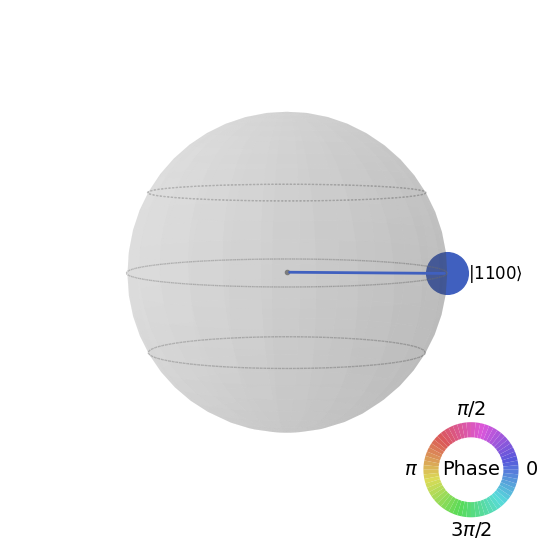

In [8]:
simulator.get_qsphere()

**City Representation**

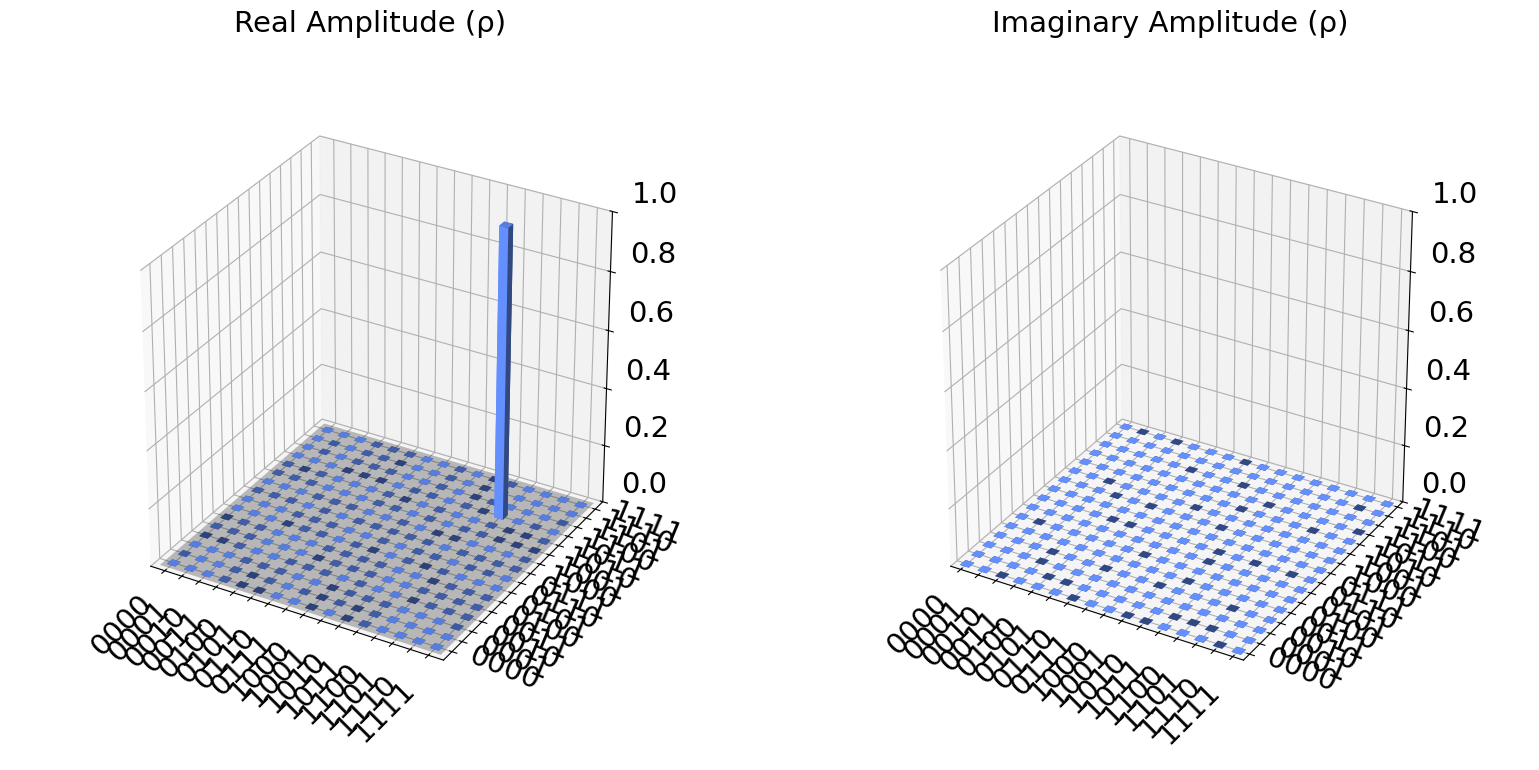

In [9]:
simulator.get_city()

**Circuit Representation**

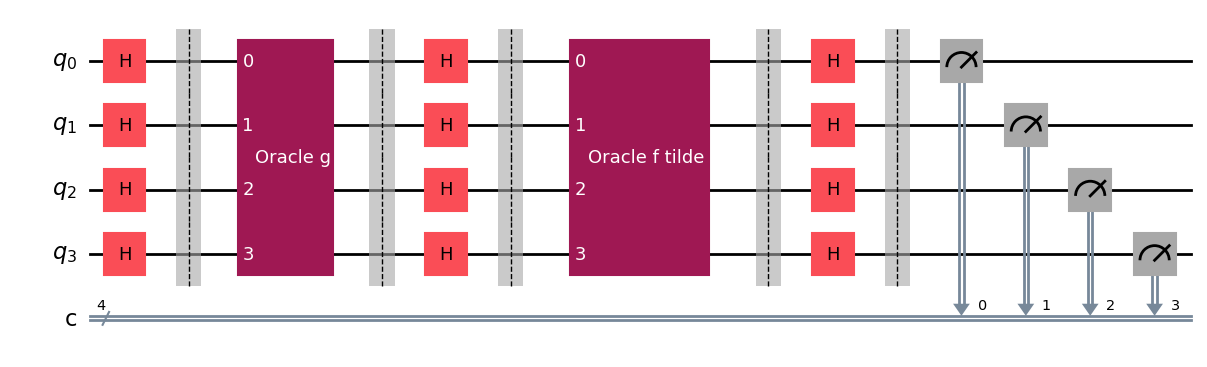

In [10]:
simulator.get_circuit()

**Hinton Representation**

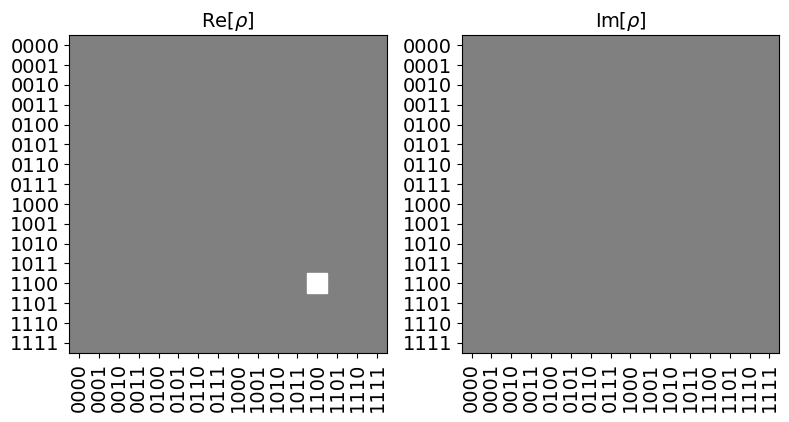

In [11]:
simulator.get_hinton()

**Paulivector Representation**

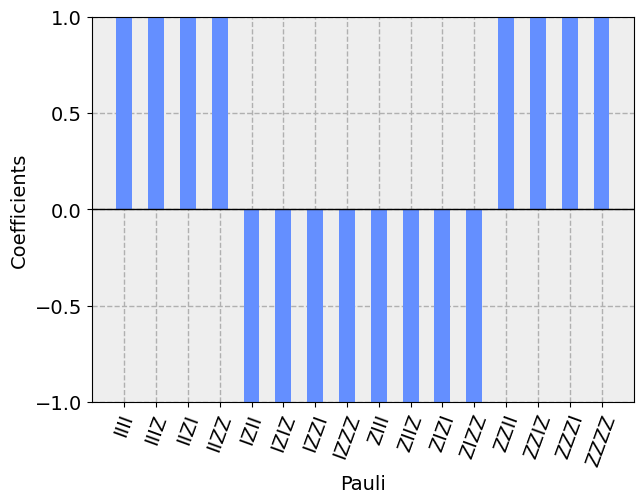

In [12]:
simulator.get_paulivec()

**Bloch sphere Representation**

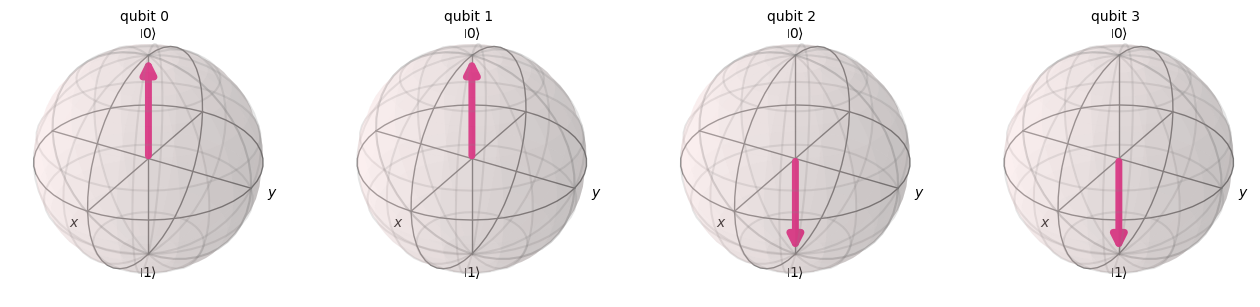

In [13]:
simulator.get_bloch()